## Bayesian Approach to Modelling 30-Day Readmissions

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import set_config

set_config(transform_output="pandas")

In [2]:
df = pd.read_csv("hf_readmissions.csv")

df.head()

,hospital_id,readmitted_30d,age,num_comorbidities,prior_admissions_last_year,insurance_type,discharge_disposition
0,H12,0,59,1,1,Medicare,Home
1,H2,1,78,8,1,Medicare,Home
2,H2,1,83,4,3,Self-pay,Skilled Nursing Facility
3,H2,0,79,3,1,Medicaid,Home
4,H3,1,95,4,2,Medicare,Home


In [3]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "standardize_age",
            StandardScaler(),
            ["age", "num_comorbidities", "prior_admissions_last_year"],
        ),
        (
            "insurance_encoder",
            "passthrough",
            ["insurance_type", "discharge_disposition", "hospital_id"],
        ),
    ],
    verbose_feature_names_out=False,
)

transformer = Pipeline(steps=[("preprocessor", preprocessor)])

In [4]:
X = transformer.fit_transform(df)
y = df["readmitted_30d"]

X.head()

,age,num_comorbidities,prior_admissions_last_year,insurance_type,discharge_disposition,hospital_id
0,-1.254897,-1.163702,-0.420678,Medicare,Home,H12
1,0.653042,2.908492,-0.420678,Medicare,Home,H2
2,1.155132,0.581524,1.214611,Self-pay,Skilled Nursing Facility,H2
3,0.753460,-0.000218,-0.420678,Medicaid,Home,H2
4,2.360146,0.581524,0.396967,Medicare,Home,H3


## Modeling Objective

Estimate hospital-specific baseline readmission risk, controlling for patient characteristics. You should use a Bayesian hierarchical logistic regression:
- Patient-level predictors adjust for differences in population.
- Hospital-level effects are modeled with partial pooling.

## 1. Model Specification

a. Write the likelihood for the binary readmission outcome.     

b. Specify the linear predictor, including:
- Patient-level predictors
- Hospital-level intercepts

c. Choose priors for:
- Patient-level regression coefficients
- The hospital-level intercept distribution (hierarchical prior)

d. State the full generative model in a compact form.

In [ ]:
H = X["hospital_id"].nunique()
hospital_idx, hospitals = pd.factorize(X["hospital_id"])
insurance_idx, insurances = pd.factorize(X["insurance_type"])
discharge_idx, discharges = pd.factorize(X["discharge_disposition"])

with pm.Model(
    coords={
        "hospitals": hospitals,
        "insurance": insurances,
        "discharges": discharges,
        "features": ["age", "comorbidities", "admissions"],
    }
) as model:
    mu_alpha = pm.Normal("mu_alpha", mu=0.0, sigma=1.5)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1.0)
    alpha_offset = pm.Normal("alpha_offset", mu=0.0, sigma=1.0, dims="hospitals")
    alpha = pm.Deterministic(
        "alpha", mu_alpha + alpha_offset * sigma_alpha, dims="hospitals"
    )

    # population-level coefficients
    betas = pm.Normal("beta", mu=0.0, sigma=10.0, dims="features")
    beta_insurance = pm.Normal("beta_insurance", mu=0.0, sigma=10.0, dims="insurance")
    beta_discharge = pm.Normal("beta_discharge", mu=0.0, sigma=10.0, dims="discharges")

    logit = (
        alpha[hospital_idx]
        + betas[0] * X["age"]
        + betas[1] * X["num_comorbidities"]
        + betas[2] * X["prior_admissions_last_year"]
        + beta_insurance[insurance_idx]
        + beta_discharge[discharge_idx]
    )

    readmissions = pm.Bernoulli("readmission_30d", p=pm.math.sigmoid(logit), observed=y)

    trace = pm.sample(2000, tune=1000)

In [ ]:
df.groupby(by="hospital_id", as_index=False).agg(prop=("readmitted_30d", "mean"))

,hospital_id,prop
0,H1,0.474708
1,H10,0.555556
2,H11,0.600000
3,H12,0.549296
4,H2,0.480154
5,H3,0.461235
6,H4,0.577778
7,H5,0.649485
8,H6,0.320388
9,H7,0.135135


In [ ]:
az.summary(trace, var_names=["mu_alpha", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_alpha,0.029,1.485,-2.843,2.737,0.016,0.018,8585.0,5684.0,1.0
alpha[H12],0.333,1.500,-2.414,3.201,0.016,0.018,8301.0,5692.0,1.0
alpha[H2],0.018,1.500,-2.694,2.916,0.016,0.018,8265.0,5634.0,1.0
alpha[H3],-0.083,1.502,-2.855,2.753,0.016,0.018,8299.0,5668.0,1.0
alpha[H8],0.545,1.500,-2.117,3.488,0.016,0.018,8265.0,5629.0,1.0
alpha[H6],-0.692,1.516,-3.496,2.192,0.017,0.018,8388.0,5837.0,1.0
alpha[H9],-0.018,1.502,-2.733,2.882,0.016,0.018,8296.0,5809.0,1.0
alpha[H4],0.455,1.502,-2.438,3.211,0.016,0.018,8291.0,5611.0,1.0
alpha[H10],0.353,1.501,-2.400,3.230,0.016,0.018,8303.0,5702.0,1.0
alpha[H7],-1.448,1.543,-4.480,1.376,0.017,0.018,8013.0,5818.0,1.0


In [ ]:
az.summary(trace, var_names=["beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[age],0.187,0.024,0.142,0.231,0.0,0.0,8930.0,5245.0,1.0
beta[comorbidities],0.412,0.025,0.367,0.461,0.0,0.0,10199.0,5671.0,1.0
beta[admissions],0.453,0.025,0.406,0.499,0.0,0.0,10517.0,6195.0,1.0


In [ ]:
az.summary(trace, var_names=["beta_insurance"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_insurance[Medicare],-0.001,3.580,-6.595,6.892,0.083,0.047,1849.0,3074.0,1.0
beta_insurance[Self-pay],0.334,3.578,-6.582,6.896,0.083,0.047,1846.0,3073.0,1.0
beta_insurance[Medicaid],0.174,3.580,-6.278,7.214,0.083,0.047,1849.0,3025.0,1.0
beta_insurance[Private],-0.197,3.580,-6.772,6.718,0.083,0.047,1851.0,3003.0,1.0


In [ ]:
az.summary(trace, var_names=["beta_discharge"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_discharge[Home],-0.220,3.567,-6.827,6.552,0.083,0.049,1829.0,2952.0,1.0
beta_discharge[Skilled Nursing Facility],0.173,3.568,-6.467,6.928,0.083,0.049,1829.0,2947.0,1.0
beta_discharge[AMA],0.981,3.568,-5.821,7.571,0.083,0.049,1844.0,3011.0,1.0
beta_discharge[Hospice],0.517,3.570,-6.217,7.204,0.083,0.049,1826.0,3029.0,1.0


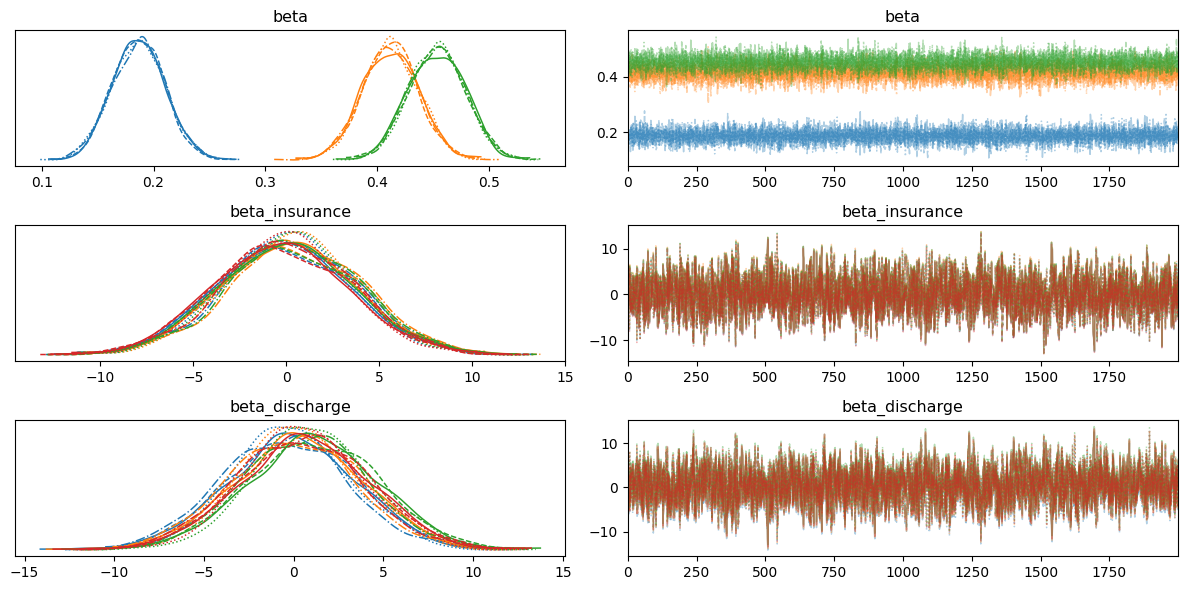

In [ ]:
az.plot_trace(trace, var_names=["beta", "beta_insurance", "beta_discharge"])
plt.tight_layout()
plt.show()